# Predictive Maintenance - Guehring Production Machines

Erstellung eines Vorhersagemodells zur Klassifizierung von "Maschinenausfall" oder "kein Maschinenausfall". 
Siehe https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020?resource=download für Datenverständnis.

In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor 
sns.set()


## I Rohdaten laden

In [3]:
original_data = pd.read_csv("/Users/marcoschwarz/Documents/Digital Business Management/Semester_2/AI/Exam/Fallstudie AI/FallstudieGuehring.csv")
original_data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# Überprüfung auf Duplikate
original_data[original_data.duplicated(keep=False)]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF


Es sind keine Duplikate vorhanden.

## II Data Understanding

#### 1. Step - Descriptive Statistik

In [5]:
original_data.describe(include='all')

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
unique,NaN,10000,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M14860,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,NaN,NaN,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,NaN,NaN,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,NaN,NaN,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,NaN,NaN,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,NaN,NaN,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,NaN,NaN,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


#### 2. Step - Nullwerte Checken

In [6]:
original_data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Keine Nullwerte vorhanden - liegt daran, dass der Datensatz synthetisch erzeugt beziehungsweise ergänzt wurde. 

### 2.1. Numerische Attribute


Zunächst werden numerische Attribute untersucht, um die Verteilung derer zu analysieren und so ein besseres Verständnis zu den einzelnen Werten zu erhalten.


In [7]:
# Einladen aller numerischer Attribute
numeric_data = original_data.select_dtypes(include=[np.number])

In [8]:
numeric_data.head()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


#### 1. Air temperature [K]

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Air temperature [K]', ylabel='Density'>

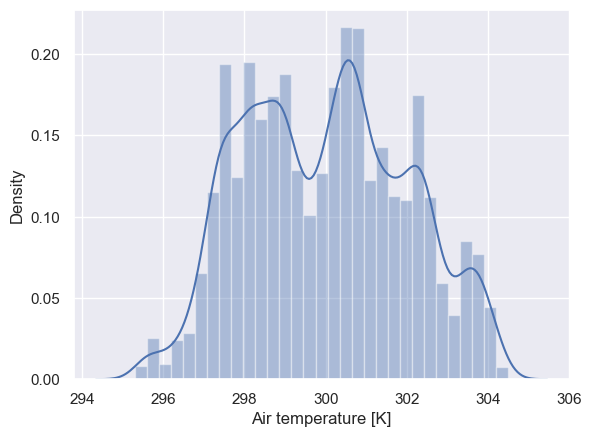

In [9]:
sns.distplot(numeric_data['Air temperature [K]'])

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Air temperature [K]', ylabel='Density'>

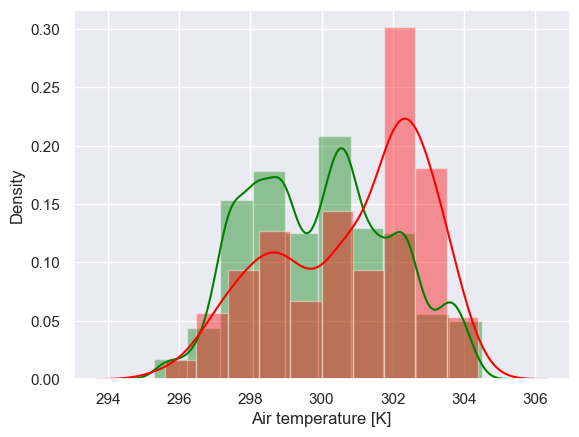

In [10]:
sns.distplot(numeric_data[numeric_data['Machine failure'] == 0]['Air temperature [K]'],
             bins=10,
             color='green',
             label='Non-Failure',
             kde=True)
sns.distplot(numeric_data[numeric_data['Machine failure'] == 1]['Air temperature [K]'],
             bins=10,
             color='red',
             label='Failure',
             kde=True)

Auffälig ist, dass bei einer Air temperature [K] im Bereich von 302 bis 304 verhältnismäßig viele Maschinenfehler auftreten. Die Kurve von "keine Maschinenfehler" nimmt hingegen in diesem Bereich stark ab. 


#### 2. Process temperature [K]

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Process temperature [K]', ylabel='Density'>

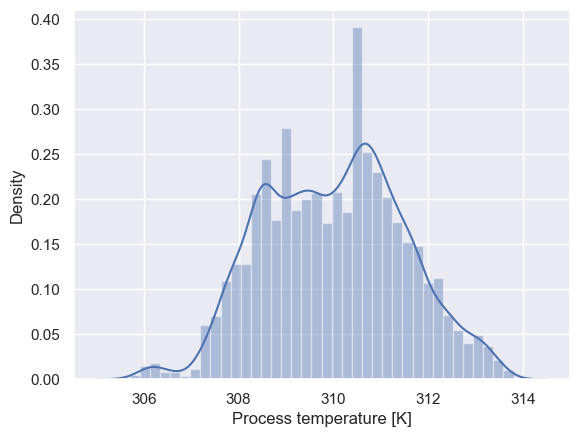

In [11]:
sns.distplot(numeric_data['Process temperature [K]'])

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Process temperature [K]', ylabel='Density'>

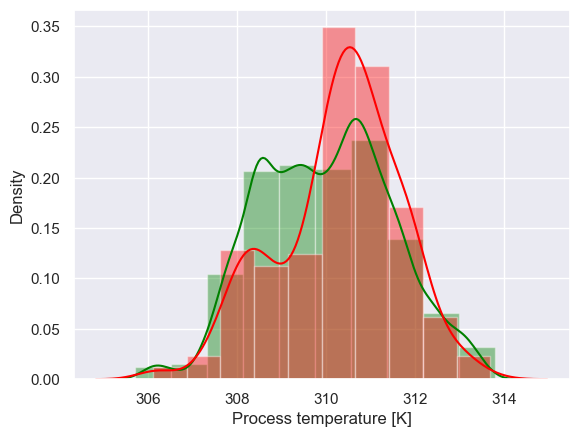

In [13]:
sns.distplot(numeric_data[numeric_data['Machine failure'] == 0]['Process temperature [K]'],
             bins=10,
             color='green',
             label='Non-Failure',
             kde=True)
sns.distplot(numeric_data[numeric_data['Machine failure'] == 1]['Process temperature [K]'],
             bins=10,
             color='red',
             label='Failure',
             kde=True)

Hier ähneln sich beide Kurven sehr stark. Lediglich im Bereich von 310 bis 312 treten verhältnismäßig mehr Maschinenfehler auf.

#### 3. Rotational speed [rpm]

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rotational speed [rpm]', ylabel='Density'>

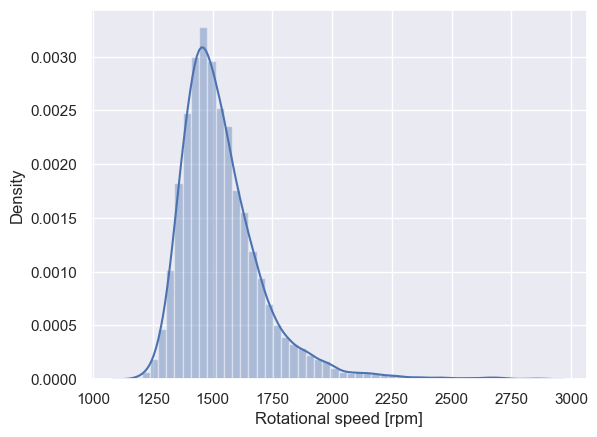

In [14]:
sns.distplot(numeric_data['Rotational speed [rpm]'])

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rotational speed [rpm]', ylabel='Density'>

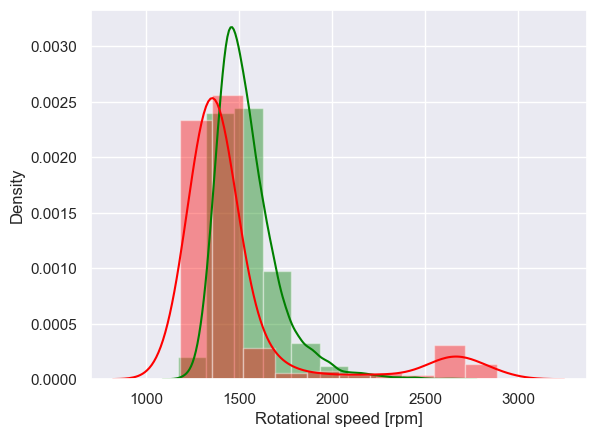

In [15]:
sns.distplot(numeric_data[numeric_data['Machine failure'] == 0]['Rotational speed [rpm]'],
             bins=10,
             color='green',
             label='Non-Failure',
             kde=True)
sns.distplot(numeric_data[numeric_data['Machine failure'] == 1]['Rotational speed [rpm]'],
             bins=10,
             color='red',
             label='Failure',
             kde=True)

Hier sind sogenannte Outliers erkennbar, diese werden in der Data Präparation entfernt, da "ungewöhnliche Beobachtungen" das spätere Modell unverhältnismäßig beeinflussen können.
>Ziel ist es eine Normalverteilung zu erzeugen, dafür werden 1% der Werte im hohen Bereich von Rotational speed [rpm] removed.


#### 4. Torque [Nm]

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Torque [Nm]', ylabel='Density'>

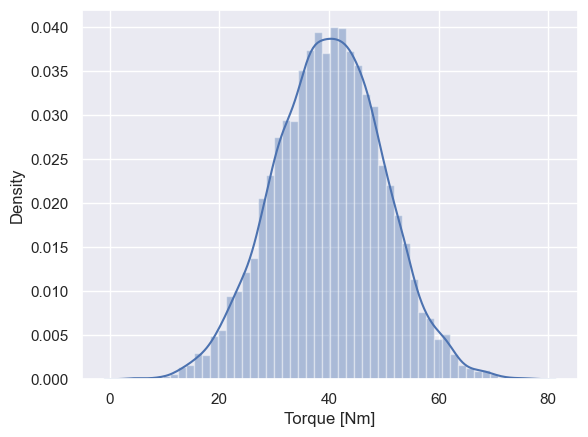

In [16]:
sns.distplot(numeric_data['Torque [Nm]'])

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Torque [Nm]', ylabel='Density'>

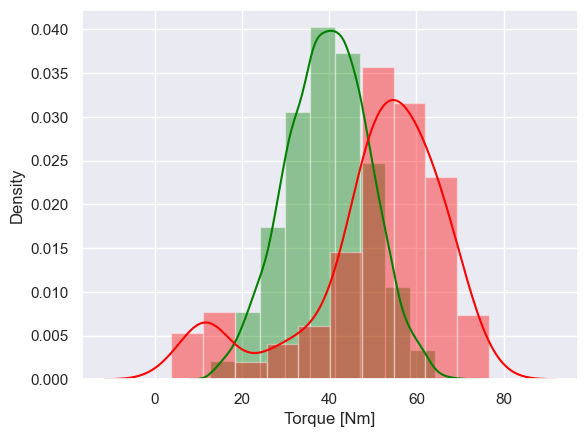

In [17]:
sns.distplot(numeric_data[numeric_data['Machine failure'] == 0]['Torque [Nm]'],
             bins=10,
             color='green',
             label='Non-Failure',
             kde=True)
sns.distplot(numeric_data[numeric_data['Machine failure'] == 1]['Torque [Nm]'],
             bins=10,
             color='red',
             label='Failure',
             kde=True)

Beim Torque [Nm] ist auffällig, dass Maschinenfehler deutlich häufiger in einem höheren Drehzahlbereich auftauchen.

#### 5. Tool wear [min]

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Tool wear [min]', ylabel='Density'>

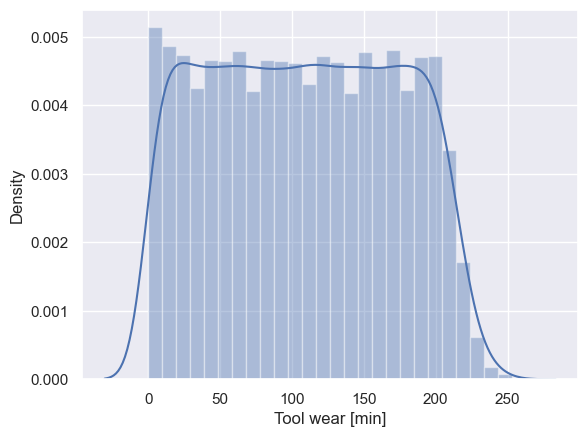

In [18]:
sns.distplot(numeric_data['Tool wear [min]'])

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Tool wear [min]', ylabel='Density'>

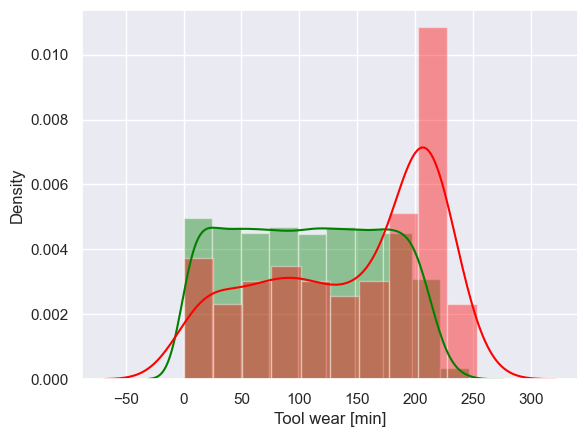

In [19]:
sns.distplot(numeric_data[numeric_data['Machine failure'] == 0]['Tool wear [min]'],
             bins=10,
             color='green',
             label='Non-Failure',
             kde=True)
sns.distplot(numeric_data[numeric_data['Machine failure'] == 1]['Tool wear [min]'],
             bins=10,
             color='red',
             label='Failure',
             kde=True)

Maschinenfehler treten auffällig oft im Bereich um 200 Minuten auf, hier ist in der Kurve ein deutlicher Anstieg zu erkennen. Dies könnte darauf hindeuten, dass bei längerer Verwendung eines Werkzeuges, auch die Fehleranfälligkeit steigt. 

### 2.2. Korrelationsmatrix der nummerischen Variablen

> In diesem Abschnitt wird die lineare Beziehung zwischen den nummerischen unabhängigen Variablen überprüft, um im weiteren Vorgehen die Multikollinearität zu reduzieren und ggf. späteres Overfitting vorzubeugen.

<AxesSubplot:>

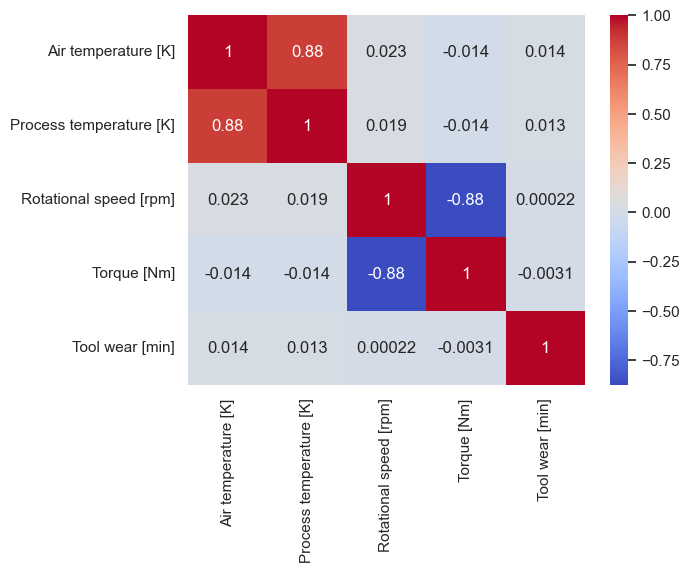

In [103]:
# Korrelation zwischen den numerischen Variablen

# Liste der Spalten, die gelöscht werden sollen
columns_to_drop = ["UDI", "TWF", "HDF", "PWF", "OSF", "RNF", "Machine failure" ]  
# Spalten löschen und Korrelation berechnen
feature_corr = numeric_data.drop(columns_to_drop, axis=1).corr()
# Heatmap anzeigen
sns.heatmap(feature_corr, annot=True, cmap='coolwarm')



##### Untersuchung von hohen Werten

- Air temperature und Prozess temperature weisen eine sehr starke Korrelation auf. Im späteren Verlauf muss diese genauer untersucht werden.

In [21]:
x1 = numeric_data['Process temperature [K]']
x2 = numeric_data ['Air temperature [K]']

In [22]:
x = sm.add_constant(x1)
results = sm.OLS(x2,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Air temperature [K]   R-squared (uncentered):                   1.000
Model:                             OLS   Adj. R-squared (uncentered):              1.000
Method:                  Least Squares   F-statistic:                          8.737e+08
Date:                 Tue, 04 Jul 2023   Prob (F-statistic):                        0.00
Time:                         15:07:33   Log-Likelihood:                         -14338.
No. Observations:                10000   AIC:                                  2.868e+04
Df Residuals:                     9999   BIC:                                  2.868e+04
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Process temperature [K]     0.9677   3.27e-05   2.96e+04      0.000       0.968       0.968
==============================================================================
Omnibus:                     2565.151   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.641
Skew:                           0.094   Prob(JB):                     3.79e-98
Kurtosis:                       1.980   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R² von 1 in Kombination mit einem hohen Regressionskoeffizienten (coef) von 0.9677 bedeutet also, dass in diese Fall die abhängige Variable "Process temperature [K]" von der abhängigen Variablen, "Air temperature [K]" beschrieben wird.

Entsprechend wird die Variable "Air temperature [K]" für das Erstellen des Modells nicht berücksichtigt.
    

<AxesSubplot:>

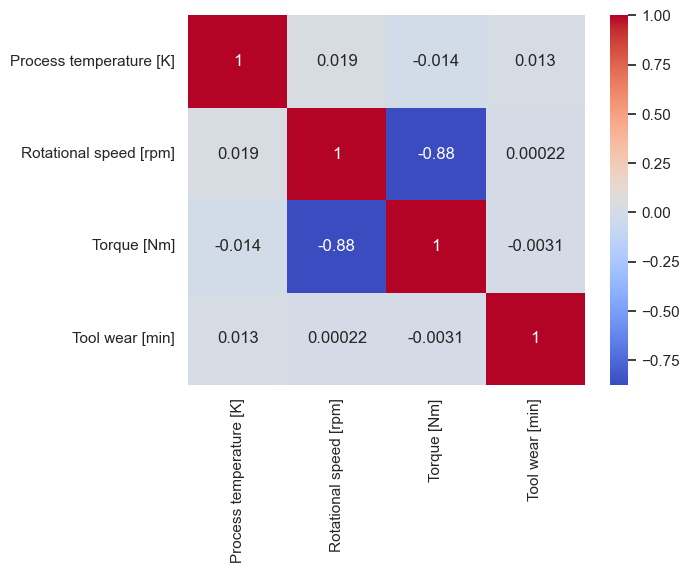

In [23]:
# Korrelation zwischen den numerischen Variablen
columns_to_drop = ["UDI", "TWF", "HDF", "PWF", "OSF", "RNF", "Machine failure", "Air temperature [K]"]  # Liste der Spalten, die gelöscht werden sollen
feature_corr = numeric_data.drop(columns_to_drop, axis=1).corr()  # Spalten löschen und Korrelation berechnen
sns.heatmap(feature_corr, annot=True, cmap='coolwarm')  # Heatmap anzeigen

In [24]:
x1 = numeric_data ['Rotational speed [rpm]']
x2 = numeric_data['Torque [Nm]'] 

In [25]:
x = sm.add_constant(x1)
results = sm.OLS(x2,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            Torque [Nm]   R-squared (uncentered):                   0.882
Model:                            OLS   Adj. R-squared (uncentered):              0.882
Method:                 Least Squares   F-statistic:                          7.493e+04
Date:                Tue, 04 Jul 2023   Prob (F-statistic):                        0.00
Time:                        15:07:36   Log-Likelihood:                         -40680.
No. Observations:               10000   AIC:                                  8.136e+04
Df Residuals:                    9999   BIC:                                  8.137e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Rotational speed [rpm]     0.0250   9.13e-05    273.736      0.000       0.025       0.025
==============================================================================
Omnibus:                      617.132   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              860.412
Skew:                          -0.549   Prob(JB):                    1.46e-187
Kurtosis:                       3.926   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Bei einem R² von 0.882 wird Rotational speed [rpm] von der in diesem Beispiel unabhängigen Variablen, Torque [Nm], stark beschrieben. Ob daher die Variable Torque [Nm] aus dem Datenset genommen wird, wird allerdings erst nach weiteren Tests entschieden.  

### 2.3. Scatterplots zwischen den nummerischen Variablen und der Zielvariable im Vergleich

> Hier werden zwei unabhängige Variablen auf ein Schaubild gebracht, um durch das Mappen der abhängigen Variablen zu analysieren, ob das Zusammenwirken einen Einfluss auf die Zielvariable hat.
> Konkret soll also untersucht werden, ob durch ein Zusammenwirken zweier unabhängigen Variablen eine Aussage hinsichtlich der Zielvariablen getroffen werden kann.

<AxesSubplot:xlabel='Process temperature [K]', ylabel='Rotational speed [rpm]'>

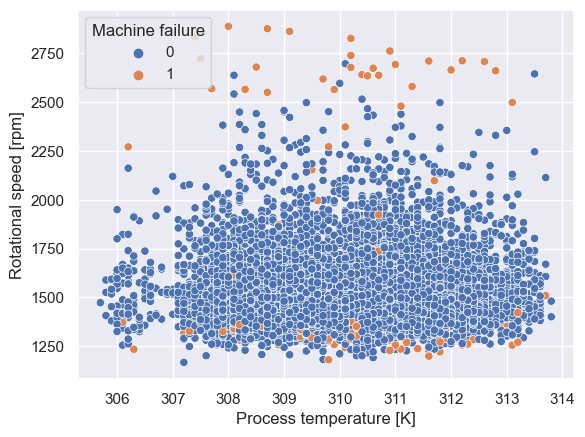

In [26]:
sns.scatterplot(data=numeric_data, x="Process temperature [K]", y="Rotational speed [rpm]", hue="Machine failure")

Auffällig ist, dass sich im oberen Bereich des Schaubildes verhältnismäßig viele orangene Punkte befinden, dies deutet entsprechend auf einen Zusammenhang zwischen einem hohen Rotational speed [rpm] und einen Maschinenausfall hin.
Hinsichtlich eines Zusammenhangs mit Process temperature [K] lässt sich keine Aussage treffen.


<AxesSubplot:xlabel='Process temperature [K]', ylabel='Torque [Nm]'>

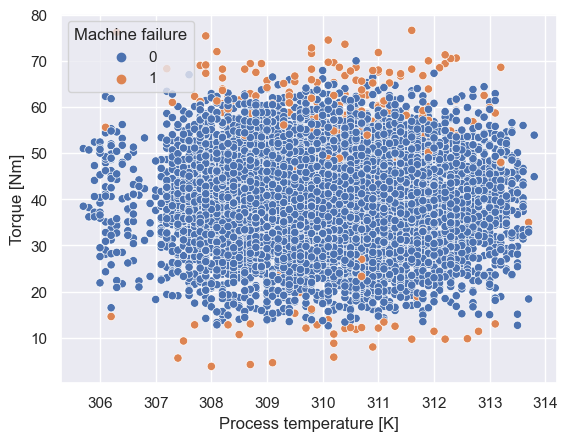

In [27]:
sns.scatterplot(data=numeric_data, x="Process temperature [K]", y="Torque [Nm]", hue="Machine failure")

Hier fällt auf, dass sich die Maschinenausfälle stark auf die sehr hohen und sehr niedrigen Torque [Nm] Bereiche verteilen. Im mittleren Breich ist nur vereinzelt mit einem Maschinenausfall zu rechnen.
Allerdings ist auch hier kein konkreter Zusammenhang mit "Process temperature [K]" zu erkennen.

<AxesSubplot:xlabel='Torque [Nm]', ylabel='Rotational speed [rpm]'>

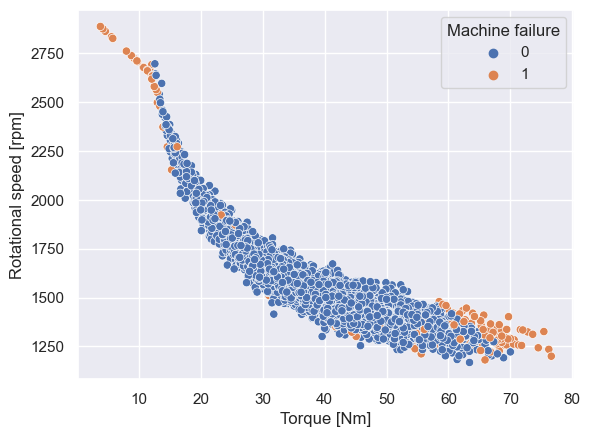

In [28]:
sns.scatterplot(data=numeric_data, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Machine failure")

Hier ist ein deutlicher Zusammenhang aus dem Zusammenspiel von Torque [Nm] und Rotational speed [rpm] auf einen Machine failure zu erkennen. Bei hohem Rotational speed [rpm] und geringem Torque [Nm], sowie bei einem hohen Torque [Nm] und einr geringen Rotational speed [rpm] sind Maschinenausfälle sehr häufig zu beobachten.

<AxesSubplot:xlabel='Rotational speed [rpm]', ylabel='Tool wear [min]'>

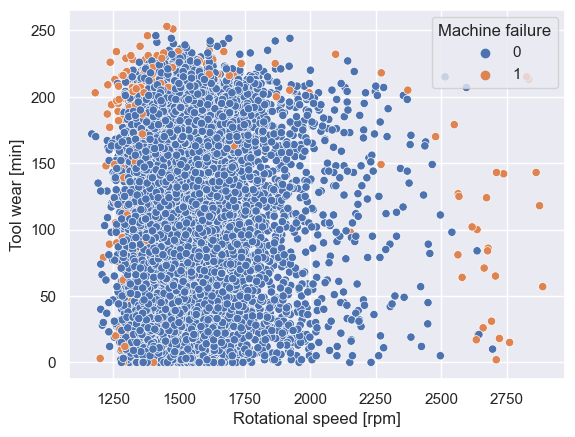

In [29]:
sns.scatterplot(data=numeric_data, x="Rotational speed [rpm]", y="Tool wear [min]", hue="Machine failure")

Hier ist die Tendenz erkennbar, dass bei hohen Werten im Bereich Tool wear [min] in Kombination mit einem niedrigen Wer bei Rotational speed [rpm] die höchste Machine failure Quote herrscht.

### 2.3. Kategoriale Attribute

L    6000
M    2997
H    1003
Name: Type, dtype: int64


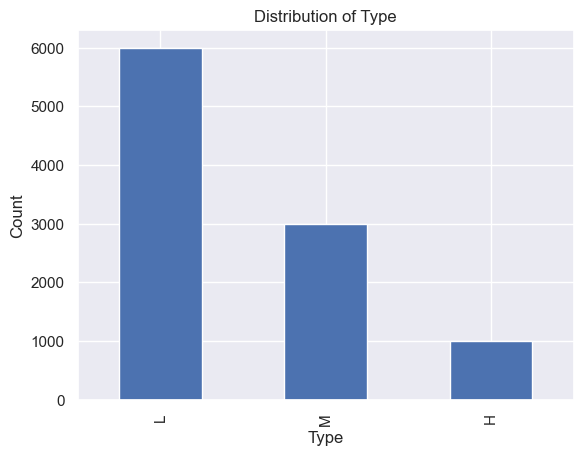

In [30]:
#Analyze gender column
gender_counts = original_data['Type'].value_counts()
print(gender_counts)

gender_counts.plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution of Type')
plt.show()

0    9954
1      46
Name: TWF, dtype: int64


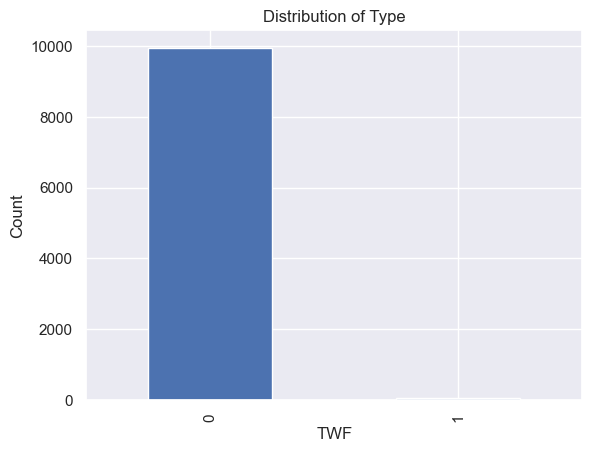

In [31]:
#Analyze gender column
gender_counts = original_data['TWF'].value_counts()
print(gender_counts)

gender_counts.plot(kind='bar')
plt.xlabel('TWF')
plt.ylabel('Count')
plt.title('Distribution of Type')
plt.show()

0    9885
1     115
Name: HDF, dtype: int64


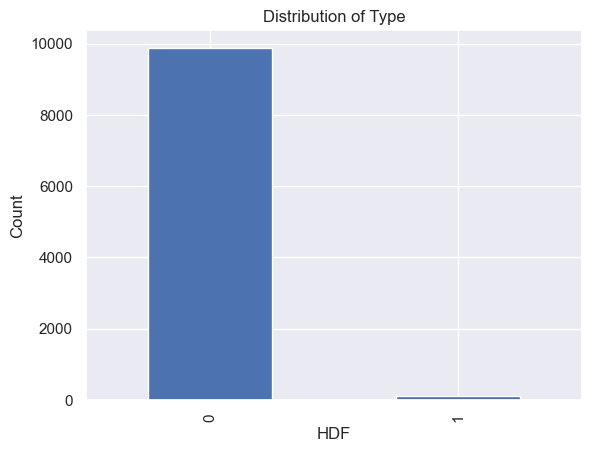

In [32]:
#Analyze gender column
gender_counts = original_data['HDF'].value_counts()
print(gender_counts)

gender_counts.plot(kind='bar')
plt.xlabel('HDF')
plt.ylabel('Count')
plt.title('Distribution of Type')
plt.show()

0    9905
1      95
Name: PWF, dtype: int64


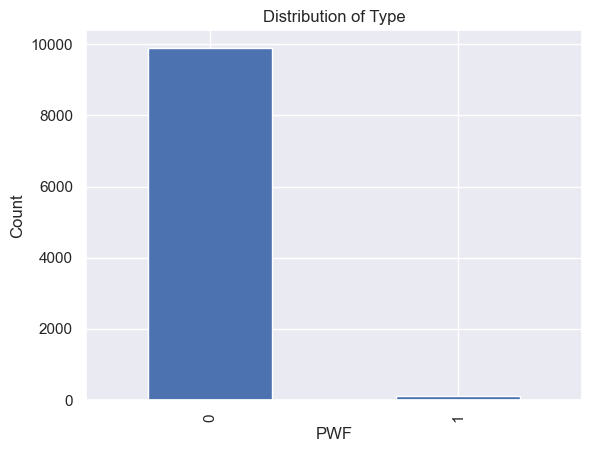

In [33]:
#Analyze gender column
gender_counts = original_data['PWF'].value_counts()
print(gender_counts)

gender_counts.plot(kind='bar')
plt.xlabel('PWF')
plt.ylabel('Count')
plt.title('Distribution of Type')
plt.show()

0    9902
1      98
Name: OSF, dtype: int64


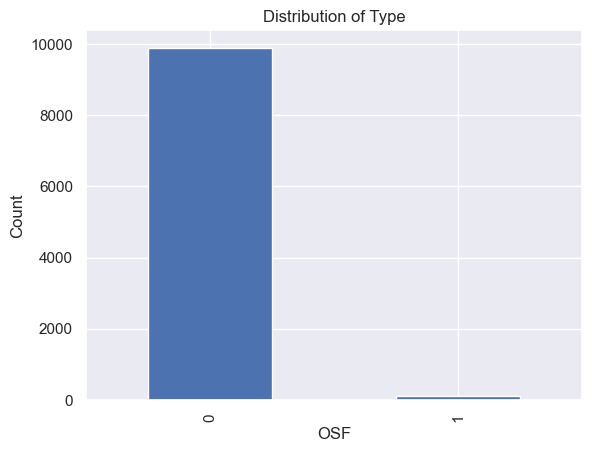

In [34]:
#Analyze gender column
gender_counts = original_data['OSF'].value_counts()
print(gender_counts)

gender_counts.plot(kind='bar')
plt.xlabel('OSF')
plt.ylabel('Count')
plt.title('Distribution of Type')
plt.show()

0    9981
1      19
Name: RNF, dtype: int64


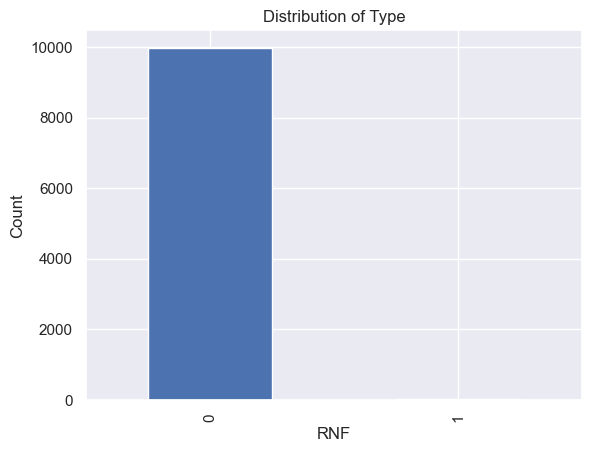

In [35]:
#Analyze gender column
gender_counts = original_data['RNF'].value_counts()
print(gender_counts)

gender_counts.plot(kind='bar')
plt.xlabel('RNF')
plt.ylabel('Count')
plt.title('Distribution of Type')
plt.show()

## III Data Präparation

### 1. UDI und Produkt ID entfernen

In [36]:
# Entfernen der Produkt ID, da keine Auswirkung und keinen Mehrwert auf Zielvar. beziehungsweise Modell
data_prep = original_data.drop("Product ID", axis = 1)

In [37]:
# Entfernen der UDI, da keine Auswirkung und keinen Mehrwert auf Zielvar. beziehungsweise Modell
data_prep = data_prep.drop("UDI", axis = 1)

### 2. Kodierung der kategorischen Variablen
> Dient zur verwendung der Daten in Type, im späteren Training des Modells.

In [38]:
bin_var = ["Type"]

In [39]:
def binaer_umwandeln(x):
    return x.map({'L':1,'M':2,'H':3})

In [40]:
data_prep[bin_var]=data_prep[bin_var].apply(binaer_umwandeln)
data_prep.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,2,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,1,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,1,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,1,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Im nächsten Schritt werden die Arten des Maschinenfehlers aus dem Datensatz herausgenommen, da sie keinen Predictor darstellen, sondern eine Spezifizierung der Zielvariablen.

In [41]:
data_reduced_features = data_prep[
    [
        "Machine failure",
        "Air temperature [K]",
        "Process temperature [K]",
        "Rotational speed [rpm]",
        "Torque [Nm]",
        "Tool wear [min]",
        "Type"
   
    ]
]

In [42]:
data_reduced_features.head()

,Machine failure,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type
0,0,298.1,308.6,1551,42.8,0,2
1,0,298.2,308.7,1408,46.3,3,1
2,0,298.1,308.5,1498,49.4,5,1
3,0,298.2,308.6,1433,39.5,7,1
4,0,298.2,308.7,1408,40.0,9,1


### 3. Outlier detection

> Aufgrund der im Data Unterstanding festgestellten Outliers in der Variablen Rotational speed [rpm], werden diese nun entspreched bereinigt.
> Dies erfolgt durch das entfernen von 1% der Werte im oberen Bereich. 

In [43]:
# Deklarieren einer Variablen, die dem 99. Perzentil der Variablen 'Rotational speed [rpm]' entspricht.
q = data_reduced_features['Rotational speed [rpm]'].quantile(0.99)

# Erstellung einer neuen Datendatei mit der Bedingung, dass alle Werte 
# unter dem 99. Perzentil von 'Rotational speed [rpm]' liegen müssen.
# Löschen der obersten 1% der Daten
data_1 = data_reduced_features[original_data['Rotational speed [rpm]']<q]

data_1.describe(include='all')

,Machine failure,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type
count,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000,9900.000000
mean,0.031111,300.002424,310.004677,1529.787475,40.251343,107.936768,1.501111
std,0.173627,1.999685,1.483608,154.946235,9.659507,63.634644,0.671606
min,0.000000,295.300000,305.700000,1168.000000,15.300000,0.000000,1.000000
25%,0.000000,298.300000,308.800000,1422.000000,33.400000,53.000000,1.000000
50%,0.000000,300.100000,310.100000,1501.000000,40.200000,108.000000,1.000000
75%,0.000000,301.500000,311.100000,1608.000000,46.800000,162.000000,2.000000
max,1.000000,304.500000,313.800000,2188.000000,76.600000,253.000000,3.000000


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Rotational speed [rpm]', ylabel='Density'>

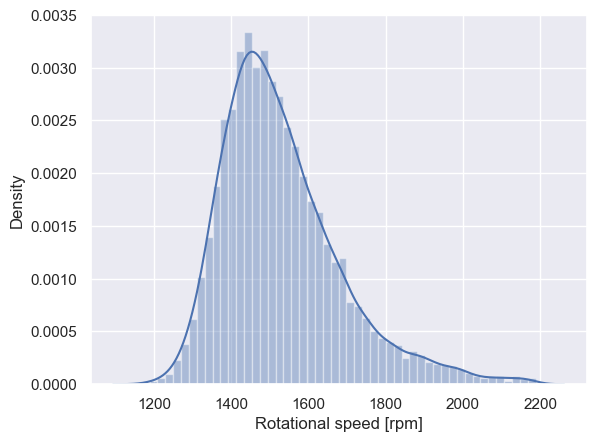

In [44]:
# Plot the new graph
sns.distplot(data_1['Rotational speed [rpm]'])

### 4. Data Types

In [45]:
# get data types of columns
column_types = data_1.dtypes

# check results
print(column_types)

# --> alle data types passen zu den Werten in den Spalten. Keine Änderung notwendig

Machine failure              int64
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Type                         int64
dtype: object


### 5. Rearrange Columns
> Spalten werden angepasst, sodass die unabhängige Variable am Anfang des Datenframes steht, gefolt von den Abhängigen.

In [46]:
# Liste mit den gewünschten Spalten erstellen (in der gewünschten Reihenfolge)
new_columns = ['Machine failure', 'Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]','Torque [Nm]', "Type"]

print(new_columns)

['Machine failure', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Type']


### 6. Reset Index
> Durch das Zurücksetzen des Index werden durch Datenanpassung entstandene Inkonsistenzen oder Fehler in der Reihenfolge behoben.

In [47]:
# reset indexes
data_resetted = data_1.reset_index(drop=True)

data_resetted.head()

,Machine failure,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type
0,0,298.1,308.6,1551,42.8,0,2
1,0,298.2,308.7,1408,46.3,3,1
2,0,298.1,308.5,1498,49.4,5,1
3,0,298.2,308.6,1433,39.5,7,1
4,0,298.2,308.7,1408,40.0,9,1


### 7. Feature Scaling

Feature Scaling wird angewendet, um die Werte von Features in einem Datensatz auf einen bestimmten Bereich zu skalieren. Dies dient dazu, sicherzustellen, dass alle Features vergleichbare Einflüsse auf das Modell haben.

In [48]:
# data_resetted soll standardisiert werden, um Einflussnahme vergleichbar zu machen.
#'Machine Failure' ist die Spalte, die von der Standardisierung ausgenommen werden soll

# Spalte 'Machine Failure' aus dem DataFrame entfernen

data_resetted_drop = data_resetted.drop('Machine failure', axis=1)


# Standardisierung durchführen
scaler = StandardScaler()
data_stand = scaler.fit_transform(data_resetted_drop)


# Standardisierte Daten in DataFrame umwandeln
data_stand = pd.DataFrame(data_stand, columns=data_resetted_drop.columns)

# Spalte 'Machine Failure' aus dem ursprünglichen DataFrame zu data_3 hinzufügen
data_stand.insert(0,'Machine failure', data_resetted['Machine failure'])





In [49]:
data_stand.head()

,Machine failure,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type
0,0,-0.951410,-0.946846,0.136909,0.263863,-1.696281,0.742867
1,0,-0.901399,-0.879439,-0.786038,0.626219,-1.649134,-0.746176
2,0,-0.951410,-1.014252,-0.205162,0.947162,-1.617703,-0.746176
3,0,-0.901399,-0.946846,-0.624684,-0.077787,-1.586272,-0.746176
4,0,-0.901399,-0.879439,-0.786038,-0.026022,-1.554841,-0.746176


In [50]:
data_stand.columns.values

array(['Machine failure', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Type'], dtype=object)

### 8. Untersuchen von Multikollinearität
> Vermeidung von zu starkem Zusammenhang zweier oder mehreren Einflussfaktoren auf das Ergebnis - Maschinenausfall oder nicht.

In [51]:
# unabhängige Variablen
vif_test = data_stand.drop("Machine failure", axis=1)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = vif_test.columns 
  
# VIF für jedes Feature 
vif_data["VIF"] = [variance_inflation_factor(vif_test.values, i) 
                          for i in range(len(vif_test.columns))] 
  
print(vif_data)

                   feature       VIF
0      Air temperature [K]  4.298659
1  Process temperature [K]  4.297964
2   Rotational speed [rpm]  4.944642
3              Torque [Nm]  4.943743
4          Tool wear [min]  1.000315
5                     Type  1.000396


VIF Werte sollten nicht über 10 liegen.
> Da in hier alle Werte unter 10 liegen liegt keine erkennbare Multikollinearität vor. Somit werden alle Features im weiteren Schritt für die Erstellung und das Training des Modells verwendet.

 ## IV Erstellung und Training des Modells
 
> In diesem Teil werden zunächst die präparierten Daten in Trainings - und Testdaten aufgesplittet, um dann nach einer Balancierung der Trainingsdaten in die Testphase und somit Validierung des Modells zu gehen. Es werden drei verschiedene Verfahren angewendet, um das bestmögliche Ergebnis zu erzielen.


### 1. Train - Test Split

In [52]:
# Ziel ist Machine failure und die Predictors, die mir zur Aussage verhelfen sollen, sind alles außer dem Target.

target = data_stand["Machine failure"]
predictors = data_stand.drop(["Machine failure"], axis=1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=123)

# 80% der Daten werden als Trainingsdaten verwendet, und die restlichen 20% dienen dem Test.

### 2. Data Balancing
> Hier werden die Trainingsdaten mittels Oversampling ausbalanciert. 
> Durch die geringere Anzahl der Klasse 1 in Machine failure, wurde ansonsten die Modellqualität stark leiden.

In [54]:
X_train

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type
6629,0.848964,0.536101,-0.088987,0.015390,-0.941937,0.742867
5973,0.348860,0.670914,-0.218070,-0.202023,-0.140446,-0.746176
6759,0.548902,0.670914,0.227268,1.247400,1.179657,-0.746176
5357,1.299058,1.547201,-1.347551,1.361283,-1.036230,-0.746176
7610,0.298850,1.142761,-0.192254,-0.367671,-1.429117,2.231911
...,...,...,...,...,...,...
9785,-0.651347,-0.340186,0.924319,-0.978499,0.519605,-0.746176
7763,0.098808,1.075354,0.111093,-0.264141,1.713984,2.231911
5218,1.799162,2.019047,-0.050262,-0.460848,0.393881,-0.746176
1346,-0.651347,0.064254,1.053403,-0.864616,-0.894790,0.742867


In [55]:
y_train.value_counts()

0    7677
1     243
Name: Machine failure, dtype: int64

In [56]:
y_train

6629    0
5973    0
6759    0
5357    0
7610    0
       ..
9785    0
7763    0
5218    0
1346    0
3582    0
Name: Machine failure, Length: 7920, dtype: int64

In [57]:
y_train.value_counts()/np.float(len(y_train))

/var/folders/43/0rd4mn_1789fwbxqpxspdgf00000gn/T/ipykernel_92174/2267344655.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train.value_counts()/np.float(len(y_train))


0    0.969318
1    0.030682
Name: Machine failure, dtype: float64

In [58]:
# Instanziierung des Oversamplers
oversample = RandomOverSampler()

In [59]:
# Anpassen und Anwenden der Transformation
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)

In [60]:
# Oversampling der Minderheitsklasse durch den RandomOverSampler
ros = RandomOverSampler(random_state = 0)
X_train_oversampled, y_train_oversampled= ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_oversampled).items()), y_train_oversampled)

[(0, 7677), (1, 7677)] 0        0
1        0
2        0
3        0
4        0
        ..
15349    1
15350    1
15351    1
15352    1
15353    1
Name: Machine failure, Length: 15354, dtype: int64


### 3. Standard Scaler anwenden
> Die Skalierung ist ein wichtiger Schritt, um sicherzustellen, dass die Merkmale in vergleichbaren Größenordnungen vorliegen und dass kein einzelnes Merkmal einen dominanten Einfluss auf den Lernalgorithmus hat.

In [61]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_oversampled_1 = scaler.transform(X_train_oversampled)
X_test = scaler.transform(X_test)

### 4. Testen unterschiedlicher Modellverfahren
> Die präparierten Daten werden nun verwendet, um drei ausgewählte Verfahren zu testen. Ziel ist es für dieses Modell, dass Verfahren zu finden, welches das geeignetste Zusammenspiel zwischen den Performancewerten - "recall", "precisiom" und der "accuracy" bietet.

Die konkrete Auswahl und entsprechende Begründung erfolgt im Teil 5.

### 4.1. Decision Tree
> Bei diesem Verfahren wird der Datensatz auf der Grundlage der Attribute aufgeteilt. Es werden dann also Entscheidungen in Form eines Baumdiagramms getroffen, um das beste Attribut für die Aufteilung auszuwählen und den Prozess fortzusetzen.

In [70]:
# Erstellen und Trainieren des Decision-Tree-Modells
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train_oversampled, y_train_oversampled)
print("train performance")
print(classification_report(y_train_oversampled, tree.predict(X_train_oversampled)))
print("test performance")
print(classification_report(y_test, tree.predict(X_test)))

# recall, wieviel der gesamt positiven wurden erkannt
# precision, wieviel der pos erkannten sind tatsächlich pos.

train performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7677
           1       1.00      1.00      1.00      7677

    accuracy                           1.00     15354
   macro avg       1.00      1.00      1.00     15354
weighted avg       1.00      1.00      1.00     15354

test performance
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1915
           1       0.57      0.51      0.54        65

    accuracy                           0.97      1980
   macro avg       0.78      0.75      0.76      1980
weighted avg       0.97      0.97      0.97      1980



/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Hier ist ein deutliches Overfitting erkennbar, der Algorithmus hat sich perfekt auf die Trainingsdaten angepasst, kann aber nur begrenzt Aussagen über die Testdaten treffen. Um diesem Zustand zu entgehen, wird im Folgenden mit verschiedenen Baumtiefen getestet.

#### Testen verschiedener Tiefen

> Durch das Testen verschiedener "Baumtiefen" soll die bestmöglichste Option ersichtlich werden und das Modell optimiert werden.

In [71]:
tree_depth = [1, 2 ,3, 4, 5, 6, 7, 8, 9, 10]
for i in tree_depth:
    
    tree = DecisionTreeClassifier(max_depth=i,random_state=1)
    tree.fit(X_train_oversampled, y_train_oversampled)
    
    print('Max tree depth: ', i)
    print("train performance")
    print(classification_report(y_train_oversampled, tree.predict(X_train_oversampled)))
    print("--------------------------------------------------------")
    print("test performance")
    print(classification_report(y_test, tree.predict(X_test)))
    print('##############################################################################')


Max tree depth:  1
train performance
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      7677
           1       0.81      0.80      0.81      7677

    accuracy                           0.81     15354
   macro avg       0.81      0.81      0.81     15354
weighted avg       0.81      0.81      0.81     15354

--------------------------------------------------------
test performance
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1915
           1       0.12      0.75      0.21        65

    accuracy                           0.82      1980
   macro avg       0.56      0.79      0.56      1980
weighted avg       0.96      0.82      0.87      1980

##############################################################################
Max tree depth:  2
train performance
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      7677
          

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted w

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7677
           1       0.97      0.99      0.98      7677

    accuracy                           0.98     15354
   macro avg       0.98      0.98      0.98     15354
weighted avg       0.98      0.98      0.98     15354

--------------------------------------------------------
test performance
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1915
           1       0.33      0.65      0.44        65

    accuracy                           0.94      1980
   macro avg       0.66      0.80      0.70      1980
weighted avg       0.97      0.94      0.95      1980

##############################################################################
Max tree depth:  9
train performance
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7677
           1       0.99      1.00      0.99    

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Für diesen Anwendungsfall ist bei einer Baumtiefe von vier, ein Ergebnis erreicht, dass sehr gut in das Bewertungsschema passen könnte. Precision: 0.21 / Recall: 0.91 / Accuracy: 0.89

#### Ausgaben der Confusion Matrix


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(92.25, 0.5, 'Predicted label')

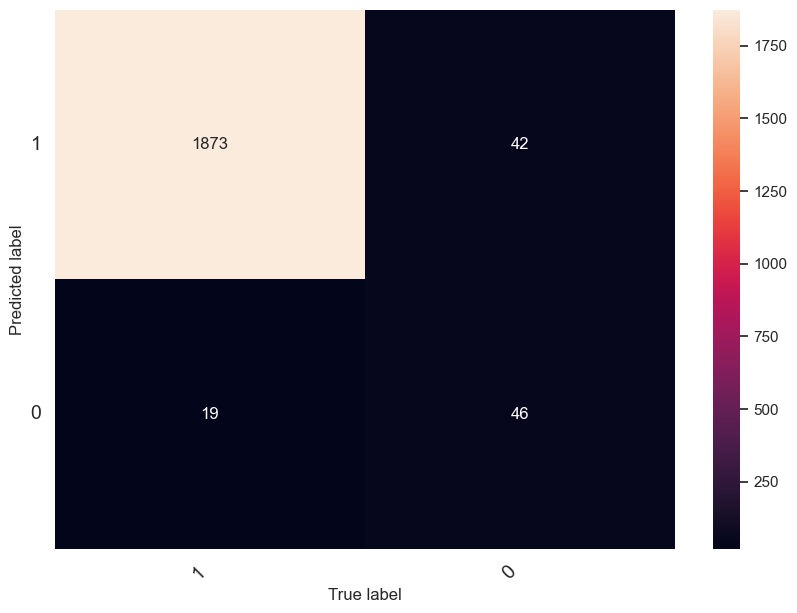

In [79]:
conf_mat = confusion_matrix(y_test, tree.predict(X_test))
df_cm = pd.DataFrame(
    conf_mat,
    index=["1", "0"],
    columns=["1", "0"],
)
fig = plt.figure(figsize=[10, 7])
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(
    heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=14
)
heatmap.xaxis.set_ticklabels(
    heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=14
)
plt.xlabel("True label")
plt.ylabel("Predicted label")

### 4.2. Logistische Regression

In [84]:
logreg = LogisticRegression(random_state=1)
logreg.fit(X_train_oversampled, y_train_oversampled)
print("train performance")
print(classification_report(y_train_oversampled, logreg.predict(X_train_oversampled)))
print("test performance")
print(classification_report(y_test, logreg.predict(X_test)))

# recall, wieviel der gesamt positiven wurden erkannt
# precision, wieviel der pos erkannten sind tatsächlich pos.

train performance
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      7677
           1       0.82      0.82      0.82      7677

    accuracy                           0.82     15354
   macro avg       0.82      0.82      0.82     15354
weighted avg       0.82      0.82      0.82     15354

test performance
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1915
           1       0.13      0.86      0.23        65

    accuracy                           0.81      1980
   macro avg       0.56      0.84      0.56      1980
weighted avg       0.97      0.81      0.87      1980



/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### Ausgaben der Confusion Matrix

/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0.5, 44.249999999999986, 'Predicted label')

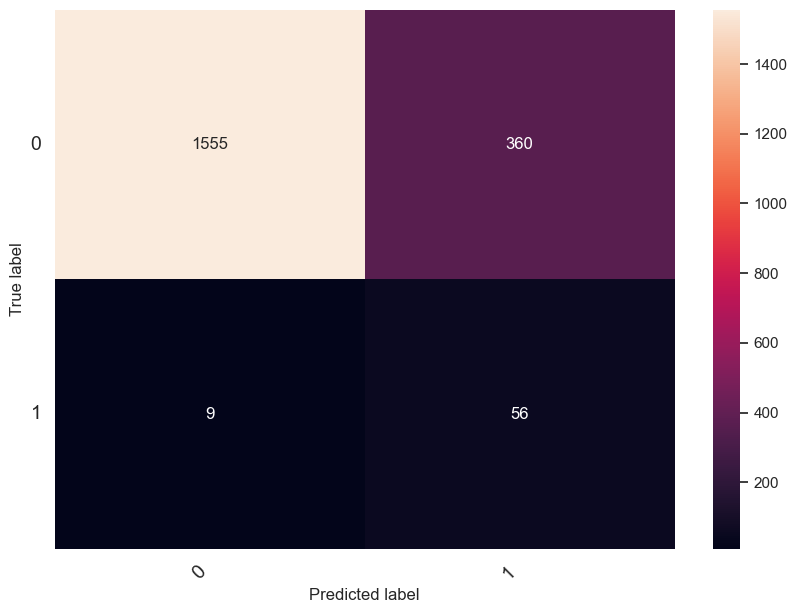

In [85]:
conf_mat = confusion_matrix(y_test, logreg.predict(X_test))
df_cm = pd.DataFrame(
    conf_mat,
    index=["0", "1"],
    columns=["0", "1"],
)
fig = plt.figure(figsize=[10, 7])
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(
    heatmap.yaxis.get_ticklabels(), rotation=0, ha="right", fontsize=14
)
heatmap.xaxis.set_ticklabels(
    heatmap.xaxis.get_ticklabels(), rotation=45, ha="right", fontsize=14
)
plt.ylabel("True label")
plt.xlabel("Predicted label")

#### Testen verschiedener Gewichtungen

In [86]:
logreg = logreg.predict_proba(X_test)[:, 1]
threshold = 0.8
logreg_new_th = (logreg >= threshold).astype(int)

print("test performance")
print(classification_report(y_test, logreg_new_th))

test performance
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1915
           1       0.32      0.63      0.43        65

    accuracy                           0.94      1980
   macro avg       0.65      0.79      0.70      1980
weighted avg       0.97      0.94      0.95      1980



/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Trotz Testung verschiedener Gewichtungen, bietet Decision Tree Methode die besseren Ergebnisse.

### 4.3. Random Forest Modeling

In [90]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train_oversampled, y_train_oversampled)
print("train performance")
print(classification_report(y_train_oversampled, rf.predict(X_train_oversampled)))
print("test performance")
print(classification_report(y_test,rf.predict(X_test)))

# recall, wieviel der gesamt positiven wurden erkannt
# precision, wieviel der pos erkannten sind tatsächlich pos.

train performance
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7677
           1       1.00      1.00      1.00      7677

    accuracy                           1.00     15354
   macro avg       1.00      1.00      1.00     15354
weighted avg       1.00      1.00      1.00     15354

test performance
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1915
           1       0.83      0.58      0.68        65

    accuracy                           0.98      1980
   macro avg       0.91      0.79      0.84      1980
weighted avg       0.98      0.98      0.98      1980



/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


> Overfitting: Der Algorithmus ist zu gut auf die Trainingsdaten angepasst.

#### Testen verschiedener Tiefen

> Durch das Testen verschiedener "Baumtiefen" soll die bestmöglichste Option ersichtlich werden und das Modell optimiert werden.

In [91]:
tree_depth = [1, 2 ,3, 4, 5, 6, 7, 8, 9, 10]
for i in tree_depth:
    
    tree = RandomForestClassifier(max_depth = i,random_state=1)
    tree.fit(X_train_oversampled, y_train_oversampled)
    
    print('Max tree depth: ', i)
    print("train performance")
    print(classification_report(y_train_oversampled, tree.predict(X_train_oversampled)))
    print("--------------------------------------------------------")
    print(classification_report(y_test, tree.predict(X_test)))
    print('##############################################################################')

Max tree depth:  1
train performance
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      7677
           1       0.83      0.83      0.83      7677

    accuracy                           0.83     15354
   macro avg       0.83      0.83      0.83     15354
weighted avg       0.83      0.83      0.83     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1915
           1       0.15      0.83      0.25        65

    accuracy                           0.84      1980
   macro avg       0.57      0.83      0.58      1980
weighted avg       0.97      0.84      0.89      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  2
train performance
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      7677
           1       0.84      0.85      0.85      7677

    accuracy                           0.85     15354
   macro avg       0.85      0.85      0.85     15354
weighted avg       0.85      0.85      0.85     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1915
           1       0.15      0.85      0.26        65

    accuracy                           0.84      1980
   macro avg       0.57      0.84      0.59      1980
weighted avg       0.97      0.84      0.89      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  3
train performance
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      7677
           1       0.86      0.96      0.91      7677

    accuracy                           0.91     15354
   macro avg       0.91      0.91      0.91     15354
weighted avg       0.91      0.91      0.91     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1915
           1       0.17      0.92      0.28        65

    accuracy                           0.84      1980
   macro avg       0.58      0.88      0.60      1980
weighted avg       0.97      0.84      0.89      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  4
train performance
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      7677
           1       0.89      0.96      0.92      7677

    accuracy                           0.92     15354
   macro avg       0.92      0.92      0.92     15354
weighted avg       0.92      0.92      0.92     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1915
           1       0.21      0.95      0.34        65

    accuracy                           0.88      1980
   macro avg       0.60      0.91      0.64      1980
weighted avg       0.97      0.88      0.91      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  5
train performance
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7677
           1       0.92      0.97      0.94      7677

    accuracy                           0.94     15354
   macro avg       0.94      0.94      0.94     15354
weighted avg       0.94      0.94      0.94     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1915
           1       0.24      0.89      0.38        65

    accuracy                           0.90      1980
   macro avg       0.62      0.90      0.66      1980
weighted avg       0.97      0.90      0.93      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  6
train performance
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      7677
           1       0.95      0.97      0.96      7677

    accuracy                           0.96     15354
   macro avg       0.96      0.96      0.96     15354
weighted avg       0.96      0.96      0.96     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1915
           1       0.30      0.88      0.45        65

    accuracy                           0.93      1980
   macro avg       0.65      0.90      0.71      1980
weighted avg       0.97      0.93      0.95      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  7
train performance
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7677
           1       0.96      0.98      0.97      7677

    accuracy                           0.97     15354
   macro avg       0.97      0.97      0.97     15354
weighted avg       0.97      0.97      0.97     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1915
           1       0.36      0.83      0.50        65

    accuracy                           0.95      1980
   macro avg       0.68      0.89      0.74      1980
weighted avg       0.97      0.95      0.96      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  8
train performance
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7677
           1       0.97      0.99      0.98      7677

    accuracy                           0.98     15354
   macro avg       0.98      0.98      0.98     15354
weighted avg       0.98      0.98      0.98     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1915
           1       0.39      0.78      0.52        65

    accuracy                           0.95      1980
   macro avg       0.69      0.87      0.75      1980
weighted avg       0.97      0.95      0.96      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  9
train performance
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7677
           1       0.98      1.00      0.99      7677

    accuracy                           0.99     15354
   macro avg       0.99      0.99      0.99     15354
weighted avg       0.99      0.99      0.99     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1915
           1       0.45      0.74      0.56        65

    accuracy                           0.96      1980
   macro avg       0.72      0.85      0.77      1980
weighted avg       0.97      0.96      0.97      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Max tree depth:  10
train performance
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7677
           1       0.98      1.00      0.99      7677

    accuracy                           0.99     15354
   macro avg       0.99      0.99      0.99     15354
weighted avg       0.99      0.99      0.99     15354

--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1915
           1       0.52      0.71      0.60        65

    accuracy                           0.97      1980
   macro avg       0.76      0.84      0.79      1980
weighted avg       0.97      0.97      0.97      1980

##############################################################################


/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Bei einer Baumtiefe von vier, konnte mit dieser Methode ein sehr gutes Ergebnis hinsichtlich der Bewertungskriterien für diesen Anwendungsfall erzielt werden.
Precision: 0.21 / Recall: 0.95 / Accuracy: 0.88

#### Testen verschiedener Gewichtungen

> Aufgrund der guten Werte bei einer Baumtiefe von 4, werden unterschiedliche Gewichtungen der beiden Klassen 0 und 1 bei diesr Baumtiefe getestet:

In [100]:
rf = RandomForestClassifier(max_depth = 4,random_state=1)
class_weights= {0:1,1:2}
rf.set_params(class_weight=class_weights)
rf.fit(X_train_oversampled, y_train_oversampled)
print("train performance")
print(classification_report(y_train_oversampled, rf.predict(X_train_oversampled)))
print("test performance")
print(classification_report(y_test,rf.predict(X_test)))

train performance
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7677
           1       0.85      0.97      0.90      7677

    accuracy                           0.90     15354
   macro avg       0.91      0.90      0.90     15354
weighted avg       0.91      0.90      0.90     15354

test performance
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1915
           1       0.15      0.95      0.26        65

    accuracy                           0.82      1980
   macro avg       0.58      0.89      0.58      1980
weighted avg       0.97      0.82      0.88      1980



/Users/marcoschwarz/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Nach dem Testen mehrerer Gewichtungen wurde klar, dass der Recall nicht weiter erhöht werden kann, sondern lediglich eine Verminderung der Precision mitsich bringt.

### 5. Auswahl und Begründung der Eignung des Verfahrens

#### 5.1. Interpretation der Werte

Beim Training des Modells, speziell bei der Auswahl des geeigneten Verfahrens wurde der Recall als zentrales Element angesehen.

>Recall drückt im konkreten Anwendungsfall, das Verhältnis zwischen tatsächlichen Maschinenfehlern und der Anzahl der durch das entwickelte Modell entdeckten Fehlern aus. (relevant found/relevant)

>Precision meint hingegen übertragen auf den Anwendungsfall, wie viele der vom Modell als Maschinenfehler deklarierten Outputs tatsächlich auch Fehler sind. (relevant found/found) 

Aufgrund von immensen Kosten eines Ausfalls und somit eines kompletten Stillstandes einer Produktionsmaschine im Vergleich zur Prüfung des ausgegebenen Fehlers, der sich im Nachhinein als nicht korrekt herausstelt, wurde der Fokus auf ein Modell gerichtet, dass in Summe die maximale Anzahl an Maschinenfehlern abdeckt. -> Recall möglichst hoch.






#### 5.2. Auswahl und Begrüdung des optimalen Modells

Zunächst wurde bei allen Vorgehensweisen darauf geachtet, dass Prozess kein Overfitting entsteht. Overfitting liegt vor, wenn ein Modell für maschinelles Lernen zu sehr an die Trainingsdaten angepasst ist und keine verallgemeinerten Vorhersagen für neue, unbekannte Daten mehr machen kann. Das Modell merkt sich dann die spezifischen Muster und das Rauschen in den Trainingsdaten, anstatt die zugrunde liegende Struktur zu erfassen.

> Nach Betrachtung all dieser Bewertungskriterien ist die Random Forest Methode mit ausgeglichener Gewichtung der Zielklassen am geeignetsten, um das Modell zu erstellen (Precision: 0.21 / Recall: 0.95 / Accuracy: 0.88).